# Experiment with Belief Networks
In this notebook, two key belief networks are experimented for stance detection.

In [1]:
from datasets import SemEval, FactmataDataset
from math import log
import numpy as np
from utils import plot_confusion_matrix
from sklearn.metrics import classification_report, precision_recall_fscore_support

## Utilities

The following cells contain functions used to extract the features from text.

In [2]:
def tokenise(text, n_s=[2, 3]):
    text = text.lower()
    for character in [",", ".", "/", "?", "!", "\"", "\'"]:
        text = text.replace(character, " " + character + " ")
    tokens = text.split()
    if n_s is not None:
        n_tokens = []
        for n in n_s:
            n_tokens += get_n_grams(tokens, n)
        tokens = tokens + n_tokens
    return tokens

In [3]:
def get_n_grams(tokens, n):
    ngrams = []
    for i in range(0, len(tokens) - n + 1):
        ngram = []
        for j in range(0, n):
            ngram.append(tokens[i + j])
        ngrams.append(" ".join(ngram))
    return ngrams

## A Belief Network with Three Variables
In the following, a belief network comprised of three variables is designed. These are the input text $x$, the stance label $y$ and the stance target $\tau$; together, they form the joint distribution $p(x, y, \tau) = p(\tau) p(y | \tau) p(x | y, \tau)$. It is assumed that $p(x) = \prod_{w \in x} p(w)$ if only 1-grams are used, else $p(x) = \prod_{i=n}^{T} p(w_i | w_{i-1}, \dots, w_{i-n+1})$.

The data is loaded - and optionally the training corpus is randomly downsampled to balance it with regards to the labels.

In [4]:
training, testing = SemEval.get_subtask_a_datasets("data/semeval/")
training = training.downsample()

In [5]:
#n_grams = None
n_grams = [2, 3]

The probability table of $p(y | \tau)$ is learnt.

In [6]:
_p_y_t = {}

In [7]:
for target, stance in zip(training.targets, training.stances):
    if target not in _p_y_t:
        _p_y_t[target] = {}
    if stance not in _p_y_t[target]:
        _p_y_t[target][stance] = 0.
    _p_y_t[target][stance] += 1.
for target in training.targets:
    for stance, value in _p_y_t[target].items():
        _p_y_t[target][stance] /= sum(_p_y_t[target].values())

In [8]:
def get_probability_of_stance_given_target(stance, target):
    return _p_y_t[target][stance]

The probability table of $p(w|y,\tau)$ is learnt.

In [9]:
_p_w_y_t = {}

In [10]:
for text, target, stance in zip(training.texts, training.targets, training.stances):
    if target not in _p_w_y_t:
        _p_w_y_t[target] = {}
    if stance not in _p_w_y_t[target]:
        _p_w_y_t[target][stance] = {}
    for token in tokenise(text, n_s=n_grams):
        if token not in _p_w_y_t[target][stance]:
            _p_w_y_t[target][stance][token] = 0.
        _p_w_y_t[target][stance][token] += 1.

In [11]:
def get_probability_of_word_given_target_and_stance(word, target, stance):
    alpha = 0.1
    numerator = _p_w_y_t[target][stance][word] if word in _p_w_y_t[target][stance] else 0.
    numerator += alpha
    denominator = sum(_p_w_y_t[target][stance].values()) + alpha * len(_p_w_y_t[target][stance])
    return numerator / denominator

In [12]:
def get_log_probability_of_text_given_target_and_stance(text, target, stance):
    _sum = 0
    for word in tokenise(text):
        _sum += log(get_probability_of_word_given_target_and_stance(word, target, stance))
    return _sum

Predictions are computed.

In [13]:
def get_prediction(text, target):
    label, log_probability = None, None
    for _label in [0, 1, 2]:
        p = get_log_probability_of_text_given_target_and_stance(text, target, _label)
        p += log(get_probability_of_stance_given_target(_label, target))
        if label is None or p > log_probability:
            log_probability = p
            label = _label
    return label

In [14]:
predictions = []
for text, target in zip(testing.texts, testing.targets):
    prediction = get_prediction(text, target)
    predictions.append(prediction)

In [15]:
print(classification_report(testing.stances, predictions))

              precision    recall  f1-score   support

           0       0.32      0.57      0.41       230
           1       0.41      0.64      0.50       304
           2       0.81      0.41      0.55       715

    accuracy                           0.50      1249
   macro avg       0.51      0.54      0.49      1249
weighted avg       0.62      0.50      0.51      1249



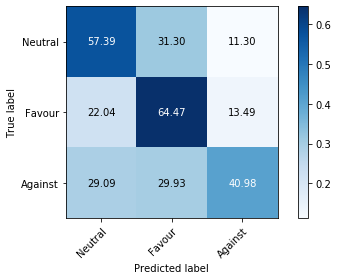

In [17]:
plot_confusion_matrix(testing.stances, predictions)

## A Belief Network with Two Variables
In the following, a belief network comprised of two variables is designed. These are the input text $x$, the stance label $y$ ; together, they form the joint distribution $p(x, y) = p(y) p(x | y)$. It is assumed that $p(x) = \prod_{w \in x} p(w)$ if only 1-grams are used, else $p(x) = \prod_{i=n}^{T} p(w_i | w_{i-1}, \dots, w_{i-n+1})$.

In [18]:
training, testing = SemEval.get_subtask_a_datasets("data/semeval/")
training = training.downsample()

In [19]:
#n_grams = None
n_grams = [2, 3]

In [20]:
p_y = {stance: training.get_label_distribution()[stance] for stance in training.get_unique_labels()}

In [21]:
p_w_y = {}

In [22]:
for text, stance in zip(training.texts, training.stances):
    if stance not in p_w_y:
        p_w_y[stance] = {}
    for token in tokenise(text, n_s=n_grams):
        if token not in p_w_y[stance]:
            p_w_y[stance][token] = 0.
        p_w_y[stance][token] += 1.

In [23]:
def get_probability_of_word_given_stance(word, stance):
    alpha = 0.1
    numerator = p_w_y[stance][word] if word in p_w_y[stance] else 0.
    numerator += alpha
    denominator = sum(p_w_y[stance].values()) + alpha * len(p_w_y[stance])
    return numerator / denominator

In [24]:
def get_log_probability_of_text_given_target_and_stance(text, stance):
    _sum = 0
    for word in tokenise(text):
        _sum += log(get_probability_of_word_given_stance(word, stance))
    return _sum

In [25]:
def get_prediction(text, target):
    label, log_probability = None, None
    for _label in [0, 1, 2]:
        p = get_log_probability_of_text_given_target_and_stance(text, _label)
        p += log(p_y[_label])
        if label is None or p > log_probability:
            log_probability = p
            label = _label
    return label

In [26]:
predictions = []
for text, target in zip(testing.texts, testing.targets):
    prediction = get_prediction(text, target)
    predictions.append(prediction)

In [27]:
print(classification_report(testing.stances, predictions))

              precision    recall  f1-score   support

           0       0.32      0.59      0.41       230
           1       0.34      0.50      0.41       304
           2       0.76      0.39      0.52       715

    accuracy                           0.46      1249
   macro avg       0.47      0.50      0.44      1249
weighted avg       0.58      0.46      0.47      1249



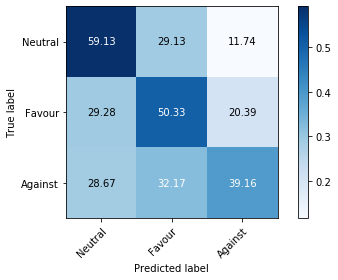

In [28]:
plot_confusion_matrix(testing.stances, predictions)